# SC1015 DSAI Mini Project
# Machine Learning
---
#### Question 1: What are the factors affecting student's stress level?

#### Question 2: What are the factors affecting student life satisfaction level?

We will be using classification models instead of regression models for our machine learning as we expect our output variable to be categorical for the problems we are looking into. We will be predicting a discrete class label in the two different problems.

We will be looking at two models first, namely the Decision Tree Classifier and Random Forest Classifier. Here are some reasons why we decided to use these two models:
- These two models were exposed to us during curriculum so it is naturally for us to adopt it first.
- Decision Tree are intuitive and good starting model to use for beginners.
- Random Forest combines multiple decision trees to improve performance, making it likely more accurate than single decision tree.

We went on to explore other models not taught in the curriculum which will be shared more under Point 6.

More details on the models and its results/parameters are presented below.

Dataset: Ideal Student Life Survery - https://www.kaggle.com/datasets/shivamb/ideal-student-life-survey/data 

## Table of Contents:
1. Data Preparation
2. Train Test Split of Dataset
3. Model 1 - Decision Tree Classifier
4. Model 2 - Random Forest Classifier
5. Results Obtained (Confusion Matrix & Classification Report)
6. Further Exploration (Other Models)
7. Conclusion
8. References

### Import Relevant Libraries & Functions

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set() 

# Import essential functions from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

### 1. Data Preparation 
#### Load & Check the Dataset 

In [2]:
# Load the data
df1 = pd.read_csv('survey_responses.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2958 entries, 0 to 2957
Data columns (total 19 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Career                                                    2958 non-null   object 
 1   Citizenship                                               2958 non-null   object 
 2   Nationality                                               2958 non-null   object 
 3   Year since Matriculation                                  2958 non-null   int64  
 4   Year of Study                                             2958 non-null   int64  
 5   Primary Programme                                         2958 non-null   object 
 6   Gender                                                    2958 non-null   object 
 7   Department                                                2958 non-null   object 
 8   Housing Type      

#### Drop Irrelevant Columns & Rows with NA values
1. 'Year since Matriculation' is essentially the same as 'Year of Study'.
2. 'Q3-How many activities are you Interested in ?' & 'Q4-How many activities are you Passionate about ?' are just internal thoughts and not actual actions that students have taken so our team feels that it is not necessary to include this 2 columns.
3. 'Q8-About How events are you aware about ?' is similar to above point, it is just awareness without actual actions.
4. 'response_id' is redundant and does not provide any insights.
5. 'Q9-What is an ideal student life ?' is a column with open-ended answers so we will be dropping it for easier processing of the machine learning models.
6. We noticed that there isn't a lot rows with NA or missing values so we decided to remove those rows instead of replacing them.

In [3]:
df1.drop(['Year since Matriculation', 
          'Q3-How many activities are you Interested in ?',
          'Q4-How many activities are you Passionate about ?', 
          'Q8-About How events are you aware about ?', 
          'response_id', 
          'Q9-What is an ideal student life ?'], axis='columns', inplace=True)
df1 = df1.dropna()

#### Convert Relevant Columns to Categorical

In [4]:
df1['Career'] = df1['Career'].astype("category")
df1['Citizenship'] = df1['Citizenship'].astype("category")
df1['Nationality'] = df1['Nationality'].astype("category")
df1['Primary Programme'] = df1['Primary Programme'].astype("category")
df1['Gender'] = df1['Gender'].astype("category")
df1['Department'] = df1['Department'].astype("category")
df1['Housing Type'] = df1['Housing Type'].astype("category")

df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2940 entries, 0 to 2939
Data columns (total 13 columns):
 #   Column                                                    Non-Null Count  Dtype   
---  ------                                                    --------------  -----   
 0   Career                                                    2940 non-null   category
 1   Citizenship                                               2940 non-null   category
 2   Nationality                                               2940 non-null   category
 3   Year of Study                                             2940 non-null   int64   
 4   Primary Programme                                         2940 non-null   category
 5   Gender                                                    2940 non-null   category
 6   Department                                                2940 non-null   category
 7   Housing Type                                              2940 non-null   category
 8   Q1-How many e

#### Apply One Hot Encoding to Categorical Columns

Various Machine Learning models are unable to work with categorical data therefore, to fix this issue we have to convert the categorical data we have into numerical data. (GeeksforGeeks, 2024)

One hot encoding is a technique that is used to represent categorical variables as numerical values for use in a machine learning model. (GeeksforGeeks, 2024) We did not use simple integer encoding for our variables as it could lead to misinterpretation and biasness. For example, when Gender are mapped, 'Male' and 'Female' will become '0' and '1' respectively but the model will give preference to 'Female' as '1' weighs more than '0' but in actual fact, both variables are equally important to the model. (GeeksforGeeks, 2024)

**Note:** We transposed the dataset to check and drop duplicates in the columns. We then tranposed the dataset back to its original orientation.

In [5]:
prefixes = ['Career', 'Citizenship', 'Nationality', 'Primary Programme', 'Gender', 'Department', 'Housing Type']
# Convert categorical columns to one-hot encoded variables with prefixes
df_encoded = pd.get_dummies(df1, prefix=prefixes)

# Concatenate encoded columns to original DataFrame
df1 = pd.concat([df1, df_encoded], axis=1)

# Drop the original categorical columns
df1.drop(['Career', 'Citizenship', 'Nationality', 'Primary Programme', 'Gender', 'Department', 'Housing Type'], axis=1, inplace=True)

# Now df contains one-hot encoded columns with specified prefixes

df1 = df1.T.drop_duplicates().T

#### Breakdown the Scale of 'Stress Level' & 'Student Life Satisfaction'

'Q5-What are your levels of stress ?' contains values on the scale of 0-9. We will be breaking this into 3 different levels - Low, Medium and High.
- Low: 0 to 3
- Medium: 4 to 6
- High: 7 to 9

'Q6-How Satisfied You are with your Student Life ?' contains values on the scale of 0-3. We will be breaking this into 3 different levels - Dissatisfied, Neutral and Satisfied.
- Dissatisfied: 0 to 1
- Neutral: 2 
- Satisfied: 3 

In [6]:
df1['Stress Level'] = pd.cut(df1['Q5-What are your levels of stress ?'], 
                             bins=[-1, 3, 7, 9], labels=['Low', 'Medium', 'High'])

df1['Student Life Satisfaction'] = pd.cut(df1['Q6-How Satisfied You are with your Student Life ?'], 
                                          bins=[-1, 1, 2, 3], labels=['Dissatisfied', 'Neutral', 'Satisfied'])

### 2. Train Test Split of Dataset
#### Create 2 Dataset - One for Stress Level Prediction & Other for Student Life Satisfaction Prediction
- Drop redundant columns for respective dataset

In [7]:
X1 = df1.drop(['Stress Level', 'Student Life Satisfaction', 'Q5-What are your levels of stress ?'], axis=1)
X2 = df1.drop(['Stress Level', 'Student Life Satisfaction', 'Q6-How Satisfied You are with your Student Life ?'], axis=1)

y_stress = df1['Stress Level']
y_satisfaction = df1['Student Life Satisfaction']

#### Spliting of the 2 Dataset 

We will be using Pareto Principle as a guiding principle to choose our train-test ratio. Pareto Principle is also known as the 80/20 rule. (Wijaya, 2023) Initially, we read an article that mentioned that if the dataset is relatively small in size (n < 10,000), 70/30 might be a better choice. (Tokuç, 2024) However, when we experimented with both ratio, we found the difference in results to be marginal, hence we stayed witht the 80/20 ratio.

Also, we set a random state to ensure we always reproduce the same results after each run.

In [8]:
X_train1, X_test1, y_train_stress, y_test_stress = train_test_split(X1, y_stress, test_size=0.2, random_state=42)
X_train2, X_test2, y_train_satisfaction, y_test_satisfaction = train_test_split(X2, y_satisfaction, test_size=0.2, random_state=42)

### 3. Model 1 - Decision Tree Classifier
- Import DecisionTreeClassifier model from sklearn
- Create two model - Stress Level Prediction & Student Life Satisfaction Prediction
- Fit the dataset into the model respectively

In [9]:
from sklearn.tree import DecisionTreeClassifier

dt_model1 = DecisionTreeClassifier()
dt_model1.fit(X_train1, y_train_stress)

dt_model2 = DecisionTreeClassifier()
dt_model2.fit(X_train2, y_train_satisfaction)

DecisionTreeClassifier()

### 4. Model 2 - Random Forest Classifier
- Import RandomForestClassifier model from sklearn
- Create two model - Stress Level Prediction & Student Life Satisfaction Prediction
- Fit the dataset into the model respectively

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_model1 = RandomForestClassifier()
rf_model1.fit(X_train1, y_train_stress)

rf_model2 = RandomForestClassifier()
rf_model2.fit(X_train2, y_train_satisfaction)

RandomForestClassifier()

### 5. Results Obtained
#### Confusion Matrix & Classification Report for Stress Level Prediction


Model: Decision Tree



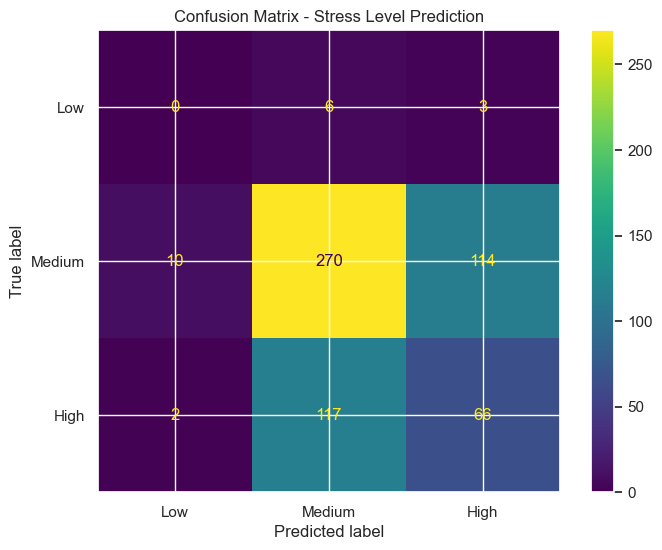

              precision    recall  f1-score   support

        High       0.00      0.00      0.00         9
         Low       0.69      0.69      0.69       394
      Medium       0.36      0.36      0.36       185

    accuracy                           0.57       588
   macro avg       0.35      0.35      0.35       588
weighted avg       0.57      0.57      0.57       588

Accuracy: 0.5714
Precision: 0.5738
Recall: 0.5714
F1-score: 0.5726
------------------------------------------------------------------------------------------------------------------------------

Model: Random Forest



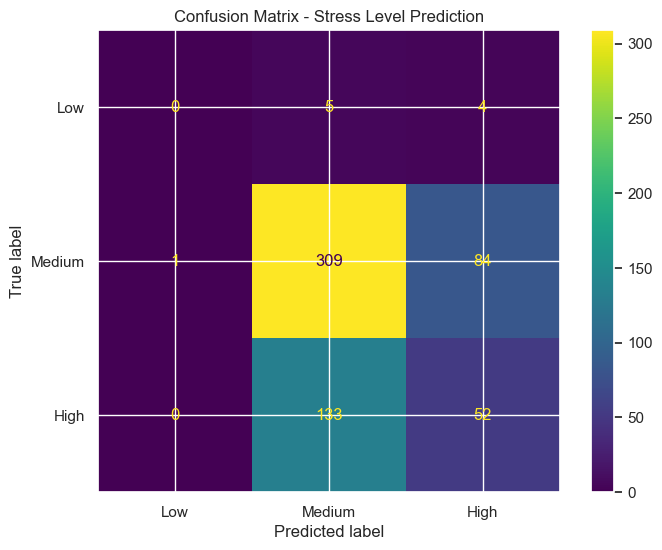

              precision    recall  f1-score   support

        High       0.00      0.00      0.00         9
         Low       0.69      0.78      0.73       394
      Medium       0.37      0.28      0.32       185

    accuracy                           0.61       588
   macro avg       0.35      0.36      0.35       588
weighted avg       0.58      0.61      0.59       588

Accuracy: 0.6139
Precision: 0.5801
Recall: 0.6139
F1-score: 0.5931
------------------------------------------------------------------------------------------------------------------------------


In [11]:
# List of tuples containing model and its name
stressmodels = [
    (dt_model1, 'Decision Tree'),
    (rf_model1, 'Random Forest'),
]

# Run for both model
for model, model_name in stressmodels:
    y_pred = model.predict(X_test1)
    cm = confusion_matrix(y_test_stress, y_pred)
    print()
    print("Model:", model_name)
    print()
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])
    disp.plot(ax=ax)
    ax.set_title('Confusion Matrix - Stress Level Prediction')
    plt.show()

    print(classification_report(y_test_stress,y_pred))
    
    accuracy = accuracy_score(y_test_stress, y_pred)
    precision = precision_score(y_test_stress, y_pred, average='weighted')
    recall = recall_score(y_test_stress, y_pred, average='weighted')
    f1 = f1_score(y_test_stress, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print('------------------------------------------------------------------------------------------------------------------------------')

#### Confusion Matrix & Classification Report for Student Life Satisfaction Prediction


Model: Decision Tree



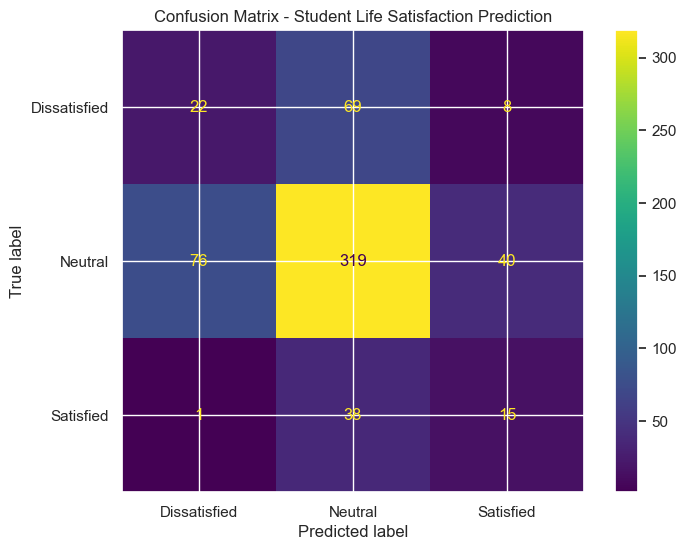

              precision    recall  f1-score   support

Dissatisfied       0.22      0.22      0.22        99
     Neutral       0.75      0.73      0.74       435
   Satisfied       0.24      0.28      0.26        54

    accuracy                           0.61       588
   macro avg       0.40      0.41      0.41       588
weighted avg       0.61      0.61      0.61       588

Accuracy: 0.6054
Precision: 0.6133
Recall: 0.6054
F1-score: 0.6092
------------------------------------------------------------------------------------------------------------------------------

Model: Random Forest



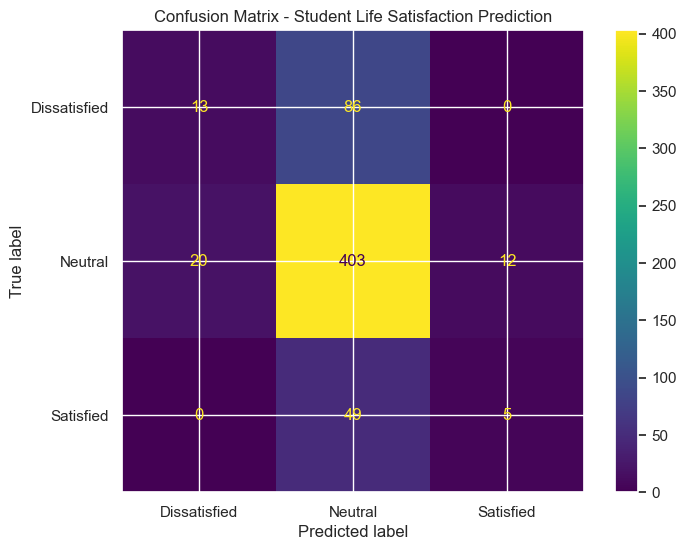

              precision    recall  f1-score   support

Dissatisfied       0.39      0.13      0.20        99
     Neutral       0.75      0.93      0.83       435
   Satisfied       0.29      0.09      0.14        54

    accuracy                           0.72       588
   macro avg       0.48      0.38      0.39       588
weighted avg       0.65      0.72      0.66       588

Accuracy: 0.7160
Precision: 0.6475
Recall: 0.7160
F1-score: 0.6589
------------------------------------------------------------------------------------------------------------------------------


In [12]:
# List of tuples containing model and its name
satismodels = [
    (dt_model2, 'Decision Tree'),
    (rf_model2, 'Random Forest'),
]

# Iterate over models
for model, model_name in satismodels:
    y_pred = model.predict(X_test2)
    cm = confusion_matrix(y_test_satisfaction, y_pred)
    print()
    print("Model:", model_name)
    print()
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dissatisfied', 'Neutral', 'Satisfied'])
    disp.plot(ax=ax)
    ax.set_title('Confusion Matrix - Student Life Satisfaction Prediction')
    plt.show()

    print(classification_report(y_test_satisfaction,y_pred))
    
    accuracy = accuracy_score(y_test_satisfaction, y_pred)
    precision = precision_score(y_test_satisfaction, y_pred, average='weighted')
    recall = recall_score(y_test_satisfaction, y_pred, average='weighted')
    f1 = f1_score(y_test_satisfaction, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print('------------------------------------------------------------------------------------------------------------------------------')

#### Choosing the Better Model
For both prediction, the values from the classification report shows that the Random Forest Classifier model is likely to have a higher accuracy, precision, recall and F1-score when compared to the Decision Tree Classifier model. This indicates that the Random Forest Classifier model was able to better accurately classify the target variable, making it the better model for the two given problem.

#### Feature Importance of the Better Model

In [13]:
importances = rf_model1.feature_importances_
feature_names = X1.columns
print("Stress Level Prediction using Random Forest Classifier")
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance.sort_values(by='Importance', ascending=False))

print()

importances = rf_model2.feature_importances_
feature_names = X2.columns
print("Student Life Satisfaction Prediction using Random Forest Classifer")
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance.sort_values(by='Importance', ascending=False))

Stress Level Prediction using Random Forest Classifier
                                              Feature  Importance
1        Q1-How many events have you Volunteered in ?    0.159951
0                                       Year of Study    0.153715
2       Q2-How many events have you Participated in ?    0.143461
4   Q7-How much effort do you make to interact wit...    0.096978
3   Q6-How Satisfied You are with your Student Life ?    0.091203
..                                                ...         ...
96          Primary Programme_Master of Science (SDE)    0.000000
61               Primary Programme_Doctor of Pharmacy    0.000000
32                                 Nationality_Poland    0.000000
34                            Nationality_Switzerland    0.000000
17                                 Nationality_France    0.000000

[127 rows x 2 columns]

Student Life Satisfaction Prediction using Random Forest Classifer
                                               Feature  Impor

### 6. Further Exploration
#### Exploring other models - Support Vector Classification (SVC) & K-Nearest Neighbors (KNN)
We found a few other models that we could potentially use and explore online such as Logistic Regression, SVC and KNN. (Mahesh, 2023) However, we realised that we are unable to use Logistic Regression as it is a model that is used for binary classification task while our case is a multi class classification task where our target variable has three possible states. (Mahesh, 2023) Next, we picked SVC as it is a powerful model which is effective in processing high dimensional data. (Mahesh, 2023) Lastly, we picked KNN as it is a model that is simple and effective and apparently, it is one of the more popular classification model. (Mahesh, 2023)

In [14]:
from sklearn.svm import SVC

svm_model1 = SVC()
svm_model1.fit(X_train1, y_train_stress)

svm_model2 = SVC()
svm_model2.fit(X_train2, y_train_satisfaction)

SVC()

In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn_model1 = KNeighborsClassifier()
knn_model1.fit(X_train1, y_train_stress)

knn_model2 = KNeighborsClassifier()
knn_model2.fit(X_train2, y_train_satisfaction)

KNeighborsClassifier()

#### Confusion Matrix & Classification Report for Stress Level Prediction


Model: SVM



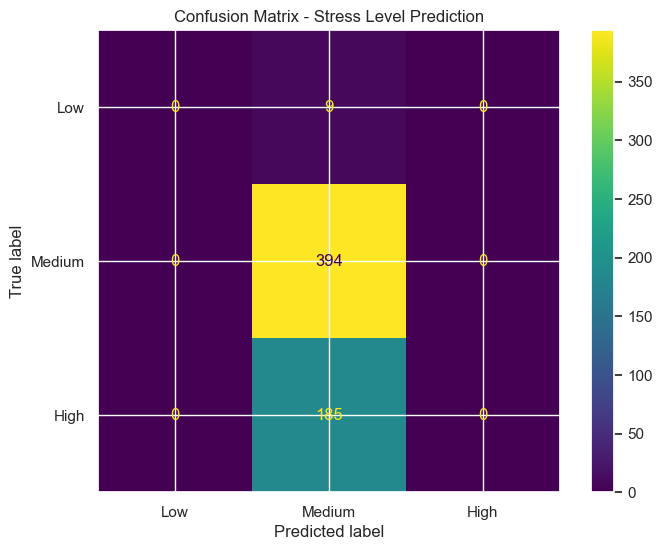

              precision    recall  f1-score   support

        High       0.00      0.00      0.00         9
         Low       0.67      1.00      0.80       394
      Medium       0.00      0.00      0.00       185

    accuracy                           0.67       588
   macro avg       0.22      0.33      0.27       588
weighted avg       0.45      0.67      0.54       588

Accuracy: 0.6701
Precision: 0.4490
Recall: 0.6701
F1-score: 0.5377
------------------------------------------------------------------------------------------------------------------------------


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


Model: K-Nearest Neighbors



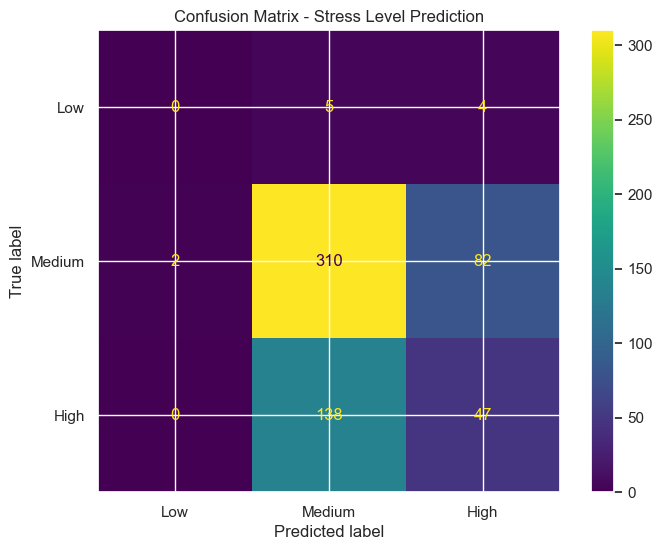

              precision    recall  f1-score   support

        High       0.00      0.00      0.00         9
         Low       0.68      0.79      0.73       394
      Medium       0.35      0.25      0.30       185

    accuracy                           0.61       588
   macro avg       0.35      0.35      0.34       588
weighted avg       0.57      0.61      0.58       588

Accuracy: 0.6071
Precision: 0.5697
Recall: 0.6071
F1-score: 0.5835
------------------------------------------------------------------------------------------------------------------------------


In [16]:
# List of tuples containing model and its name
newstressmodels = [
    (svm_model1, 'SVM'),
    (knn_model1, 'K-Nearest Neighbors')
]

# Iterate over models
for model, model_name in newstressmodels:
    y_pred = model.predict(X_test1)
    cm = confusion_matrix(y_test_stress, y_pred)
    print()
    print("Model:", model_name)
    print()
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])
    disp.plot(ax=ax)
    ax.set_title('Confusion Matrix - Stress Level Prediction')
    plt.show()

    print(classification_report(y_test_stress,y_pred))
    
    accuracy = accuracy_score(y_test_stress, y_pred)
    precision = precision_score(y_test_stress, y_pred, average='weighted')
    recall = recall_score(y_test_stress, y_pred, average='weighted')
    f1 = f1_score(y_test_stress, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print('------------------------------------------------------------------------------------------------------------------------------')

#### Confusion Matrix & Classification Report for Student Life Satisfaction Prediction


Model: SVM



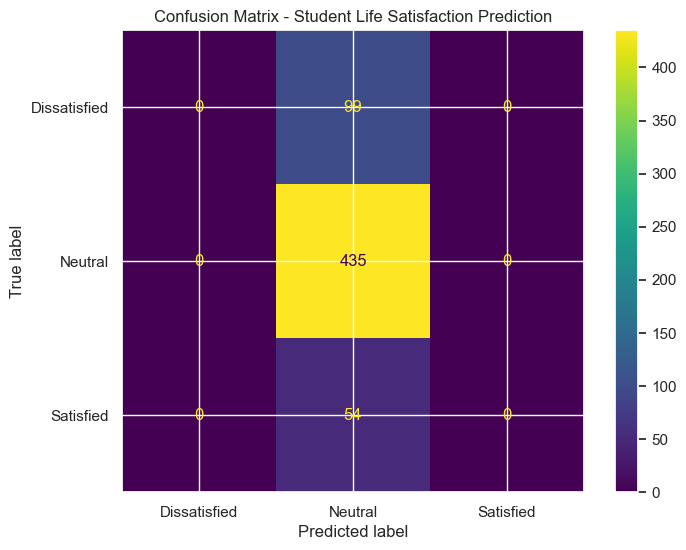

              precision    recall  f1-score   support

Dissatisfied       0.00      0.00      0.00        99
     Neutral       0.74      1.00      0.85       435
   Satisfied       0.00      0.00      0.00        54

    accuracy                           0.74       588
   macro avg       0.25      0.33      0.28       588
weighted avg       0.55      0.74      0.63       588

Accuracy: 0.7398
Precision: 0.5473
Recall: 0.7398
F1-score: 0.6292
------------------------------------------------------------------------------------------------------------------------------

Model: K-Nearest Neighbors



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

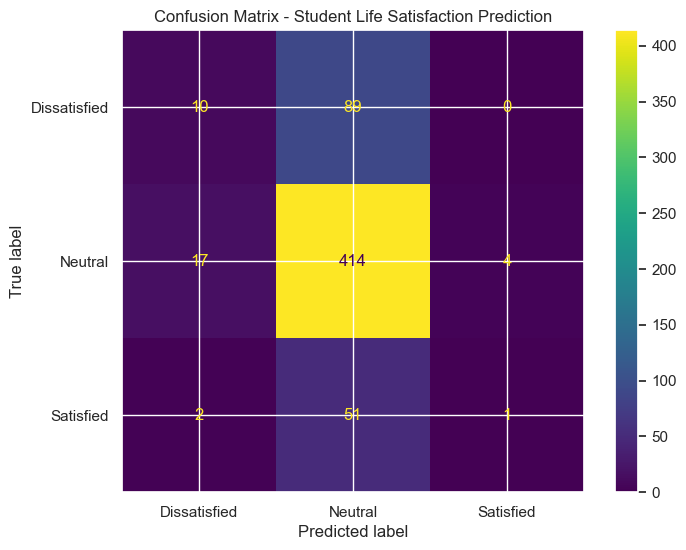

              precision    recall  f1-score   support

Dissatisfied       0.34      0.10      0.16        99
     Neutral       0.75      0.95      0.84       435
   Satisfied       0.20      0.02      0.03        54

    accuracy                           0.72       588
   macro avg       0.43      0.36      0.34       588
weighted avg       0.63      0.72      0.65       588

Accuracy: 0.7228
Precision: 0.6293
Recall: 0.7228
F1-score: 0.6488
------------------------------------------------------------------------------------------------------------------------------


In [17]:
# List of tuples containing model and its name
newsatismodels = [
    (svm_model2, 'SVM'),
    (knn_model2, 'K-Nearest Neighbors')
]

# Iterate over models
for model, model_name in newsatismodels:
    y_pred = model.predict(X_test2)
    cm = confusion_matrix(y_test_satisfaction, y_pred)
    print()
    print("Model:", model_name)
    print()
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dissatisfied', 'Neutral', 'Satisfied'])
    disp.plot(ax=ax)
    ax.set_title('Confusion Matrix - Student Life Satisfaction Prediction')
    plt.show()

    print(classification_report(y_test_satisfaction,y_pred))
    
    accuracy = accuracy_score(y_test_satisfaction, y_pred)
    precision = precision_score(y_test_satisfaction, y_pred, average='weighted')
    recall = recall_score(y_test_satisfaction, y_pred, average='weighted')
    f1 = f1_score(y_test_satisfaction, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print('------------------------------------------------------------------------------------------------------------------------------')

#### Comparing Random Forest Classifier to SVC & KNN
Both SVC and KNN appears to be better models when compared to Random Forest Classifier as the most of the metrics are higher at one glance. 

However, for SVC, we can see that it has particularly low precision score for both predictions, which may indicate that it not that good of a model. Precision is how precise the model is predicting for predicted positive, and in our case, we would want to prioritise precision as by knowing precisely why students have **high** stress or why students are **satisfied** with student life, we can better help students. (Shung, 2020) 

As for KNN, it seems to perform similarly to Random Forest Classifier in terms of all the metrics.

**Note:** There are warning messages for SVC. The warnings indicate that the precision metric for SVC is 0.0 for some labels because there are no predicted samples for those labels. This may mean that SVC is undesirable for our problem.

### 7. Conclusion
To sum up, each model has their own pros and cons and there won't be a model that excel in all kinds of dataset/problem. When choosing the best/right model for a problem, it is important keep in mind the following considerations:
- Type of Problem (e.g. Classification, Regression)
- Data you are working with (e.g. Size of Dataset, Type of Data)
- Compare Performance Metrics (e.g. Accuracy, Precision)
- Consider the Context of the Problem
- Don't limit to just one kind of model, experiment with multiple models.

### 8. References
GeeksforGeeks. (2024, March 21). One hot encoding in machine learning. https://www.geeksforgeeks.org/ml-one-hot-encoding/ 

Mahesh. (2023, June 13). Exploring decision trees, random forest, logistic regression, KNN, linear regression, SVM, RNN... Medium. https://medium.com/@maheshhkanagavell/exploring-decision-trees-random-forest-logistic-regression-knn-linear-regression-svm-rnn-bf52fa94a066 

Shung, K. P. (2020, April 10). Accuracy, precision, recall or F1?. Medium. https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9 

Tokuç, A. A. (2024, March 18). Splitting a dataset into train and test sets. Baeldung on Computer Science. https://www.baeldung.com/cs/train-test-datasets-ratio 

Wijaya, C. Y. (2023, February 2). Pareto Principle in Machine Learning Development: Work Smarter, not Harder. Non-Brand Data. https://cornellius.substack.com/p/pareto-principle-in-machine-learning 